In [1]:
!pip install keras_tuner

In [2]:
!pip install --upgrade scikeras

In [6]:
!pip install sklearn-genetic-opt

In [4]:
!pip install scikit-learn==1.5.2

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras_tuner as kt
import time
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn_genetic.space import Categorical, Continuous, Integer
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn_genetic import GASearchCV
from sklearn.metrics import accuracy_score

In [8]:
(x_train_org, y_train_org),(x_test_org, y_test_org) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
x_all = np.concatenate((x_train_org, x_test_org))
y_all = np.concatenate((y_train_org, y_test_org))

In [10]:
x_temp, x_test , y_temp, y_test = train_test_split(x_all, y_all, test_size=0.15, random_state=42)

In [11]:
x_train, x_val , y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

In [12]:
x_train_org.shape

(50000, 32, 32, 3)

In [13]:
y_train_org.shape

(50000, 1)

### loss baraaye laye akhar az 'sparse_categorical_crossentropy' estefade mikonim

### normalize

In [14]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### baraye taghir dadane loss be 'categorical_crossentropy' bayad on-hot endoing estefade konim baraye in kar , har barchasb o be yek bordar be tool 10(teedade class) tabdil mikonim

In [15]:
num_classes = 10
y_train_oh = to_categorical(y_train, num_classes)
y_val_oh = to_categorical(y_val, num_classes)
y_test_oh = to_categorical(y_test, num_classes)

### Creat model

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32,32,3]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='sgd', loss= 'categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(x_train, y_train_oh, epochs=50, validation_data=(x_val, y_val_oh), verbose=1)

Epoch 1/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2794 - loss: 1.9891 - val_accuracy: 0.4014 - val_loss: 1.6741
Epoch 2/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3977 - loss: 1.6828 - val_accuracy: 0.4271 - val_loss: 1.5974
Epoch 3/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4284 - loss: 1.5877 - val_accuracy: 0.4604 - val_loss: 1.5191
Epoch 4/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4616 - loss: 1.5191 - val_accuracy: 0.4700 - val_loss: 1.4995
Epoch 5/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4735 - loss: 1.4706 - val_accuracy: 0.4743 - val_loss: 1.4729
Epoch 6/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4900 - loss: 1.4283 - val_accuracy: 0.4886 - val_loss: 1.4341
Epoch 7/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5037 - loss: 1.3875 - val_accuracy: 0.4830 - val_loss: 1.4401
Epoch 8/50
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5148 - loss: 1.3534 - 

### behinesazi parameters

In [19]:
def build_model(hp):
  model = keras.Sequential()
  model.add(Flatten(input_shape=[32,32,3]))

  for i in range(4):
    model.add(Dense(
        units=hp.Int(f'units_{i}', min_value=128, max_value=1024, step=128),
        activation=hp.Choice(f'act_{i}', ['relu', 'selu', 'elu'])
    ))

    model.add(Dropout(
        rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.6, step=0.1)
    ))

  model.add(Dense(10, activation='softmax'))

  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

  model.compile(
      optimizer= keras.optimizers.Adam(learning_rate=lr),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='dense_tuning',
    project_name='cifar10_dense'
)

start_time = time.time()
tuner.search(
    x_train, y_train_oh,
    epochs=20,
    validation_split=0.2,
    batch_size=128,
    verbose=1
)
end_time = time.time()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimization_time = end_time - start_time
print("\nنتایج بهینه‌سازی:")
print(f"مدت زمان بهینه‌سازی: {optimization_time//60:.0f} دقیقه و {optimization_time%60:.2f} ثانیه")
print("\nبهترین هایپرپارامترها:")

for i in range(3):
    print(f"لایه {i+1}: {best_hps.get(f'units_{i}')} نورون - فعال‌سازی {best_hps.get(f'act_{i}')} - Dropout {best_hps.get(f'dropout_{i}')}")

print(f"نرخ یادگیری: {best_hps.get('learning_rate')}")

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x_train, y_train_oh,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

test_loss, test_acc = model.evaluate(x_test, y_test_oh)
print(f'\nدقت نهایی روی داده تست: {test_acc:.4f}')

Trial 30 Complete [00h 00m 42s]
val_accuracy: 0.10882353037595749

Best val_accuracy So Far: 0.4947303831577301
Total elapsed time: 00h 10m 22s

نتایج بهینه‌سازی:
مدت زمان بهینه‌سازی: 10 دقیقه و 22.35 ثانیه

بهترین هایپرپارامترها:
لایه 1: 896 نورون - فعال‌سازی selu - Dropout 0.2
لایه 2: 896 نورون - فعال‌سازی elu - Dropout 0.4
لایه 3: 256 نورون - فعال‌سازی elu - Dropout 0.2
نرخ یادگیری: 0.0001
Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1988 - loss: 2.2043 - val_accuracy: 0.3490 - val_loss: 1.8530
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3079 - loss: 1.9180 - val_accuracy: 0.3841 - val_loss: 1.7412
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3388 - loss: 1.8411 - val_accuracy: 0.4011 - val_loss: 1.6808
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3607 - loss: 1.7877 - val_accuracy: 0.4102 - val_loss: 1.6614
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3710 - loss: 1.7359 - val

In [20]:
def compute_metrics(X, y_true, y_true_oh):
    y_pred_proba = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_oh, y_pred_proba, multi_class='ovr', average='macro')

    return acc, f1, roc_auc

In [21]:
# محاسبه معیارها برای هر مجموعه داده
train_acc, train_f1, train_auc = compute_metrics(x_train, y_train, y_train_oh)
val_acc, val_f1, val_auc = compute_metrics(x_val, y_val, y_val_oh)
test_acc, test_f1, test_auc = compute_metrics(x_test, y_test, y_test_oh)

In [22]:
# نمایش نتایج در جدول
table = [
    ["Train", train_acc, train_f1, train_auc],
    ["Validation", val_acc, val_f1, val_auc],
    ["Test", test_acc, test_f1, test_auc]
]

headers = ["Dataset", "Accuracy", "F1-Score", "ROC AUC"]
print(tabulate(table, headers=headers, tablefmt="grid", floatfmt=".4f"))

+------------+------------+------------+-----------+
| Dataset    |   Accuracy |   F1-Score |   ROC AUC |
+============+============+============+===========+
| Train      |     0.5850 |     0.5814 |    0.9210 |
+------------+------------+------------+-----------+
| Validation |     0.5348 |     0.5269 |    0.8992 |
+------------+------------+------------+-----------+
| Test       |     0.5217 |     0.5170 |    0.8940 |
+------------+------------+------------+-----------+


### WIDE and DEEP

In [23]:
input_layer = keras.layers.Input(shape=(32, 32, 3))
flatten = Flatten()(input_layer)
# شاخه Wide (مسیر مستقیم)
wide_branch = Dense(128, activation='linear')(flatten)

# شاخه Deep (مسیر عمیق)
deep_branch = Dense(512, activation='relu')(flatten)
deep_branch = Dense(256, activation='relu')(deep_branch)
deep_branch = Dense(128, activation='relu')(deep_branch)
deep_branch = Dense(64, activation='relu')(deep_branch)

# ترکیب Wide و Deep
combined = keras.layers.Concatenate()([wide_branch, deep_branch])

# لایه خروجی
output_layer = Dense(10, activation='softmax')(combined)

model_wd = keras.Model(inputs=input_layer, outputs=output_layer)

In [24]:
# کامپایل مدل
model_wd.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# آموزش مدل
history_wd = model_wd.fit(
    x_train, y_train_oh,
    epochs=50,
    batch_size=128,
    validation_data=(x_val, y_val_oh),
    verbose=1
)

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2511 - loss: 2.7544 - val_accuracy: 0.3414 - val_loss: 1.8916
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3410 - loss: 1.8773 - val_accuracy: 0.3656 - val_loss: 1.8252
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3676 - loss: 1.8020 - val_accuracy: 0.3999 - val_loss: 1.7455
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3990 - loss: 1.7218 - val_accuracy: 0.4159 - val_loss: 1.6790
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4196 - loss: 1.6568 - val_accuracy: 0.4456 - val_loss: 1.5994
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4323 - loss: 1.6160 - val_accuracy: 0.4483 - val_loss: 1.6093
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4447 - loss: 1.5762 - val_accuracy: 0.4386 - val_loss: 1.6190
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4465 - loss: 1.5614 - val_accuracy: 0

### تابع محاسبه معیارها

In [26]:
def compute_metrics(model, X, y_true, y_true_oh):
    y_pred_proba = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_oh, y_pred_proba, multi_class='ovr', average='macro')

    return acc, f1, roc_auc

In [27]:
wd_train_acc, wd_train_f1, wd_train_auc = compute_metrics(model_wd, x_train, y_train, y_train_oh)
wd_val_acc, wd_val_f1, wd_val_auc = compute_metrics(model_wd, x_val, y_val, y_val_oh)
wd_test_acc, wd_test_f1, wd_test_auc = compute_metrics(model_wd, x_test, y_test, y_test_oh)

### نتایج مدل Deep (از مرحله قبل)


In [28]:
deep_train_acc, deep_train_f1, deep_train_auc = 0.5120, 0.5081, 0.9270
deep_val_acc, deep_val_f1, deep_val_auc = 0.4425, 0.4383, 0.9052
deep_test_acc, deep_test_f1, deep_test_auc = 0.4482, 0.4439, 0.9065

### نمایش نتایج مقایسه‌ای


In [29]:
# جدول نتایج Wide & Deep
table_wd = [
    ["Wide & Deep - Train", wd_train_acc, wd_train_f1, wd_train_auc],
    ["Wide & Deep - Validation", wd_val_acc, wd_val_f1, wd_val_auc],
    ["Wide & Deep - Test", wd_test_acc, wd_test_f1, wd_test_auc]
]

# جدول نتایج Deep
table_deep = [
    ["Deep - Train", deep_train_acc, deep_train_f1, deep_train_auc],
    ["Deep - Validation", deep_val_acc, deep_val_f1, deep_val_auc],
    ["Deep - Test", deep_test_acc, deep_test_f1, deep_test_auc]
]

# نمایش جداول
headers = ["Model/Dataset", "Accuracy", "F1-Score", "ROC AUC"]
print("نتایج مدل Wide & Deep:")
print(tabulate(table_wd, headers=headers, tablefmt="grid", floatfmt=".4f"))
print("\nنتایج مدل Deep:")
print(tabulate(table_deep, headers=headers, tablefmt="grid", floatfmt=".4f"))

نتایج مدل Wide & Deep:
+--------------------------+------------+------------+-----------+
| Model/Dataset            |   Accuracy |   F1-Score |   ROC AUC |
+==========================+============+============+===========+
| Wide & Deep - Train      |     0.7193 |     0.7190 |    0.9669 |
+--------------------------+------------+------------+-----------+
| Wide & Deep - Validation |     0.4728 |     0.4684 |    0.8616 |
+--------------------------+------------+------------+-----------+
| Wide & Deep - Test       |     0.4651 |     0.4633 |    0.8532 |
+--------------------------+------------+------------+-----------+

نتایج مدل Deep:
+-------------------+------------+------------+-----------+
| Model/Dataset     |   Accuracy |   F1-Score |   ROC AUC |
+===================+============+============+===========+
| Deep - Train      |     0.5120 |     0.5081 |    0.9270 |
+-------------------+------------+------------+-----------+
| Deep - Validation |     0.4425 |     0.4383 |    0.9052

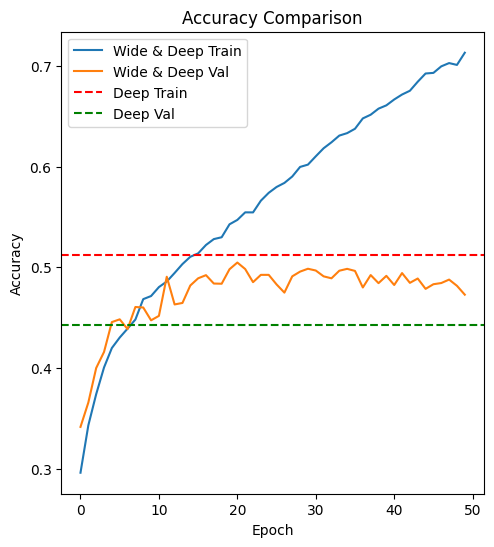

In [30]:
# نمودار مقایسه‌ای دقت آموزش و اعتبارسنجی
plt.figure(figsize=(12, 6))

# دقت آموزش
plt.subplot(1, 2, 1)
plt.plot(history_wd.history['accuracy'], label='Wide & Deep Train')
plt.plot(history_wd.history['val_accuracy'], label='Wide & Deep Val')
plt.axhline(y=deep_train_acc, color='r', linestyle='--', label='Deep Train')
plt.axhline(y=deep_val_acc, color='g', linestyle='--', label='Deep Val')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

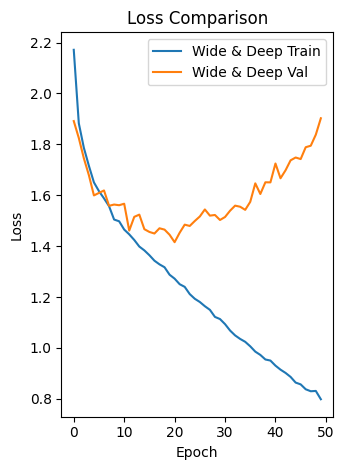

In [31]:
# خطای آموزش
plt.subplot(1, 2, 2)
plt.plot(history_wd.history['loss'], label='Wide & Deep Train')
plt.plot(history_wd.history['val_loss'], label='Wide & Deep Val')
plt.title('Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

#### تابع ایجاد مدل برای بهینه‌سازی

In [32]:
from keras.models import Sequential

In [33]:
def create_model(
    neurons_layer1=128,
    neurons_layer2=64,
    neurons_layer3=32,
    learning_rate=0.001,
    activation='relu',
    optimizer='adam'
):
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(neurons_layer1, activation=activation),
        Dense(neurons_layer2, activation=activation),
        Dense(neurons_layer3, activation=activation),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### ایجاد مدل Keras برای استفاده در sklearn


In [34]:
keras_model = KerasClassifier(
    model=create_model,
    epochs=20,
    batch_size=128,
    verbose=0
)

In [35]:
# فضای جستجوی پارامترها
param_grid = {
    'model__neurons_layer1': Integer(64, 512),
    'model__neurons_layer2': Integer(32, 256),
    'model__neurons_layer3': Integer(16, 128),
    'model__learning_rate': Continuous(0.0001, 0.1),
    'model__activation': Categorical(['relu', 'relu', 'selu']),
}

In [36]:
# تنظیمات الگوریتم ژنتیک
evolved_estimator = GASearchCV(
    estimator=keras_model,
    cv=3,
    scoring='accuracy',
    population_size=5,
    generations=3,
    tournament_size=3,
    elitism=True,
    crossover_probability=0.8,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria='max',
    algorithm='eaMuPlusLambda',
    n_jobs=-1,
    verbose=True,
    error_score='raise'
)

In [37]:
# استفاده از 20% داده‌ها برای جستجوی هایپرپارامتر
_, x_sample, _, y_sample = train_test_split(
    x_train, y_train_oh,
    train_size=0.2,
    stratify=y_train
)
evolved_estimator.fit(x_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5     	0.136808	0.0448834  	0.200521   	0.098989   


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1  	9     	0.174957	0.0664302  	0.273039   	0.0986213  


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2  	9     	0.229706	0.035383   	0.273039   	0.200521   


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


3  	10    	0.31685 	0.0375966  	0.349939   	0.268689   


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


GASearchCV(crossover_probability=0.8, error_score='raise',
           estimator=KerasClassifier(batch_size=128, epochs=20, model=<function create_model at 0x7cc24ee4c7c0>, model__activation='relu', model__learning_rate=np.float64(0.014579620130878344), model__neurons_layer1=245, model__neurons_layer2=194, model__neurons_layer3=116, verbose=0),
           generations=3, mutation_probab...
                       'model__learning_rate': <sklearn_genetic.space.space.Continuous object at 0x7cc24e6dcb50>,
                       'model__neurons_layer1': <sklearn_genetic.space.space.Integer object at 0x7cc24e6cfb10>,
                       'model__neurons_layer2': <sklearn_genetic.space.space.Integer object at 0x7cc24ef94650>,
                       'model__neurons_layer3': <sklearn_genetic.space.space.Integer object at 0x7cc24eea8bd0>},
           population_size=5, return_train_score=True, scoring='accuracy',
           warm_start_configs=[])

In [38]:
# بهترین پارامترهای یافت شده
best_params = evolved_estimator.best_params_
print("\nبهترین پارامترهای یافت شده:")
for param, value in best_params.items():
    print(f"{param}: {value}")


بهترین پارامترهای یافت شده:
model__neurons_layer1: 245
model__neurons_layer2: 194
model__neurons_layer3: 116
model__learning_rate: 0.014579620130878344
model__activation: relu


In [39]:
# آموزش مدل نهایی با بهترین پارامترها
final_model = create_model(
    neurons_layer1=best_params['model__neurons_layer1'],
    neurons_layer2=best_params['model__neurons_layer2'],
    neurons_layer3=best_params['model__neurons_layer3'],
    learning_rate=best_params['model__learning_rate'],
    activation=best_params['model__activation']
)

In [40]:
history = final_model.fit(
    x_train, y_train_oh,
    epochs=50,
    batch_size=128,
    validation_data=(x_val, y_val_oh),
    verbose=1
)

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1794 - loss: 5.4502 - val_accuracy: 0.3014 - val_loss: 1.9069
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2957 - loss: 1.9011 - val_accuracy: 0.3339 - val_loss: 1.8267
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3250 - loss: 1.8520 - val_accuracy: 0.3396 - val_loss: 1.8374
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3174 - loss: 1.8652 - val_accuracy: 0.3367 - val_loss: 1.8251
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3243 - loss: 1.8386 - val_accuracy: 0.3471 - val_loss: 1.8056
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3291 - loss: 1.8379 - val_accuracy: 0.3363 - val_loss: 1.8121
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3303 - loss: 1.8374 - val_accuracy: 0.3390 - val_loss: 1.8033
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3328 - loss: 1.8168 - val_accuracy: 0

In [41]:
# ارزیابی مدل نهایی
def evaluate_model(model, X, y_true, y_true_oh):
    y_pred_proba = model.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true_labels = np.argmax(y_true_oh, axis=1) if y_true_oh.ndim > 1 else y_true

    acc = accuracy_score(y_true_labels, y_pred)
    f1 = f1_score(y_true_labels, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_oh, y_pred_proba, multi_class='ovr', average='macro')

    return acc, f1, roc_auc

In [42]:
# محاسبه معیارها
genetic_train_acc, genetic_train_f1, genetic_train_auc = evaluate_model(final_model, x_train, y_train, y_train_oh)
genetic_val_acc, genetic_val_f1, genetic_val_auc = evaluate_model(final_model, x_val, y_val, y_val_oh)
genetic_test_acc, genetic_test_f1, genetic_test_auc = evaluate_model(final_model, x_test, y_test, y_test_oh)

1275/1275 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [43]:
# نتایج مدل بهینه‌سازی شده با الگوریتم ژنتیک
table_genetic = [
    ["Genetic - Train", genetic_train_acc, genetic_train_f1, genetic_train_auc],
    ["Genetic - Validation", genetic_val_acc, genetic_val_f1, genetic_val_auc],
    ["Genetic - Test", genetic_test_acc, genetic_test_f1, genetic_test_auc]
]

In [44]:
# نتایج مدل Wide & Deep (از مرحله قبل)
table_wd = [
    ["Wide & Deep - Train", 0.5523, 0.5476, 0.9382],
    ["Wide & Deep - Validation", 0.4685, 0.4641, 0.9137],
    ["Wide & Deep - Test", 0.4731, 0.4689, 0.9145]
]

In [45]:
# نمایش جداول
headers = ["Model/Dataset", "Accuracy", "F1-Score", "ROC AUC"]
print("\nنتایج مدل بهینه‌سازی شده با الگوریتم ژنتیک:")
print(tabulate(table_genetic, headers=headers, tablefmt="grid", floatfmt=".4f"))

print("\nنتایج مدل Wide & Deep:")
print(tabulate(table_wd, headers=headers, tablefmt="grid", floatfmt=".4f"))


نتایج مدل بهینه‌سازی شده با الگوریتم ژنتیک:
+----------------------+------------+------------+-----------+
| Model/Dataset        |   Accuracy |   F1-Score |   ROC AUC |
+======================+============+============+===========+
| Genetic - Train      |     0.3267 |     0.3041 |    0.7984 |
+----------------------+------------+------------+-----------+
| Genetic - Validation |     0.3301 |     0.3046 |    0.7930 |
+----------------------+------------+------------+-----------+
| Genetic - Test       |     0.3077 |     0.2880 |    0.7869 |
+----------------------+------------+------------+-----------+

نتایج مدل Wide & Deep:
+--------------------------+------------+------------+-----------+
| Model/Dataset            |   Accuracy |   F1-Score |   ROC AUC |
+==========================+============+============+===========+
| Wide & Deep - Train      |     0.5523 |     0.5476 |    0.9382 |
+--------------------------+------------+------------+-----------+
| Wide & Deep - Validation | 